In [ ]:
# uso del comando emcee

In [80]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
from random import random
import corner
%matplotlib inline

<ErrorbarContainer object of 3 artists>

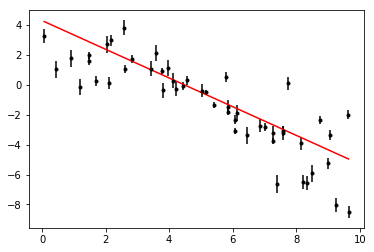

In [81]:
import numpy as np

# Cambio de los verdaderos parametros
m_v = -0.9594
b_v = 4.294
f_v = 0.534

# ghenera la simetria del modelo.
N = 50   # entrega el numero de datos
x = np.sort(10*np.random.rand(N))
yerr = 0.1+0.5*np.random.rand(N)
y = m_v*x+b_v
y += np.abs(f_v*y) * np.random.randn(N)
y += yerr * np.random.randn(N)

pl.plot(x, m_v*x+b_v, color="r") # disyribucion de recta
pl.errorbar(x, y, yerr=yerr, fmt=".k")

In [82]:
A = np.vstack((np.ones_like(x), x)).T
C = np.diag(yerr * yerr)
cov = np.linalg.inv(np.dot(A.T, np.linalg.solve(C, A)))  #calculo de la cavarianza
b_ls, m_ls = np.dot(cov, np.dot(A.T, np.linalg.solve(C, y)))

In [83]:
def lnlike(theta, x, y, yerr):  # definicion del sigma
    m, b, lnf = theta
    model = m * x + b
    inv_sigma2 = 1.0/(yerr**2 + model**2*np.exp(2*lnf))
    return -0.5*(np.sum((y-model)**2*inv_sigma2 - np.log(inv_sigma2)))

In [84]:
import scipy.optimize as op
nll = lambda *args: -lnlike(*args)
result = op.minimize(nll, [m_v, b_v, np.log(f_v)], args=(x, y, yerr))
m_ml, b_ml, lnf_ml = result["x"]

In [85]:
def lnprior(theta):
    m, b, lnf = theta
    if -5.0 < m < 0.5 and 0.0 < b < 10.0 and -10.0 < lnf < 1.0:
        return 0.0
    return -np.inf

In [86]:
def lnprob(theta, x, y, yerr):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, x, y, yerr)

In [93]:
ndim, nwalkers = 3, 100
pos = [result["x"] + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]
#print(pos)


In [ ]:
# usando el comando emcee

In [78]:
import emcee
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(x, y, yerr))

In [79]:
sampler.run_mcmc(pos, 500)

(array([[-0.9903532 ,  4.2384296 , -0.47671148],
        [-0.88427297,  3.95306608, -0.49067842],
        [-1.08759728,  4.93596066, -0.68576155],
        [-0.9927435 ,  4.51174812, -0.56181267],
        [-0.86656424,  4.04835161, -0.48109305],
        [-0.9455187 ,  4.11723031, -0.61924404],
        [-0.92303634,  4.00192484, -0.69492265],
        [-0.88498402,  4.00785975, -0.45720867],
        [-1.05345997,  4.67345546, -0.55739077],
        [-1.03043506,  4.622261  , -0.59661393],
        [-0.95322866,  4.11132339, -0.62478804],
        [-0.93607009,  3.93854955, -0.55732858],
        [-0.94214342,  4.17823655, -0.42989598],
        [-0.90199303,  3.95431524, -0.42712187],
        [-0.91224855,  3.95482651, -0.57434202],
        [-1.02276439,  4.51615431, -0.61348801],
        [-1.09506234,  4.93474897, -0.64221785],
        [-1.02104443,  4.5842316 , -0.65072769],
        [-0.99398159,  4.28892668, -0.55343293],
        [-0.98660445,  4.4677289 , -0.7322776 ],
        [-1.07137346

In [97]:
samples = sampler.chain[:, 50:, :].reshape((-1, ndim))


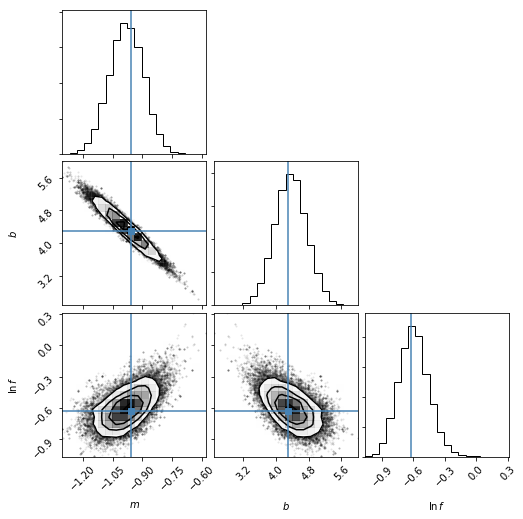

In [98]:
import corner
fig = corner.corner(samples, labels=["$m$", "$b$", "$\ln\,f$"],
                      truths=[m_v, b_v, np.log(f_v)])
fig.savefig("triangle.png") # observaciones de las graficas tanto de barras como de acumulacion de puntos

<ErrorbarContainer object of 3 artists>

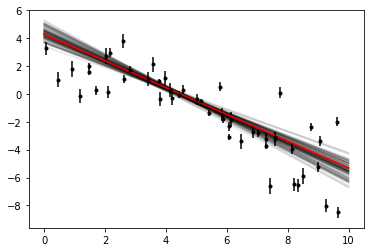

In [95]:
import matplotlib.pyplot as pl
xl = np.array([0, 10])
for m, b, lnf in samples[np.random.randint(len(samples), size=100)]:
    pl.plot(xl, m*xl+b, color="k", alpha=0.1)
pl.plot(xl, m_true*xl+b_true, color="r", lw=2, alpha=0.8)
pl.errorbar(x, y, yerr=yerr, fmt=".k")

In [91]:
samples[:, 2] = np.exp(samples[:, 2])
m_mcmc, b_mcmc, f_mcmc = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]),
                             zip(*np.percentile(samples, [16, 50, 84],
                                                axis=0)))